## 循环神经网络 Recurrent Neural Network，RNN
### 一、深度神经网络处理文本的劣势：
1. 参数过多：每个单词均拥有各自的权重和偏置---解决方法：权重共享
2. 无法保留以前时刻的信息---解决方法：设置一个信息单元$h_t$，用以保留信息
$$h_t=f(h_{t-1},x)=tanh(w_rh_{t-1}+w_ix_t)$$
$$y_t=w_oh_t$$
$$tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$  
该方法即为RNN的思想

### 二、RNN的训练方法
关键在于计算梯度向量$\frac{\partial E_t}{\partial w_r}$
$$\frac{\partial E_t}{\partial w_r}=\sum_{i=0}^{t}\frac{\partial E_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}\frac{\partial h_t}{\partial h_i}\frac{\partial h_i}{\partial w_r}

其中，$$\frac{\partial h_t}{\partial h_i}=\prod_{k=i}^{t-1}\frac{\partial h_{k+1}}{\partial h_k}$$
$$\frac{\partial h_{k+1}}{\partial h_k}=w_r diag\left[f^{'}(w_r h_k+w_i x_{k+1})\right]$$
观察解析式可得，存在多个$w_r$相乘——问题所在。
### 三、代码
#### （一）文本数据预处理

In [1]:
from io import open
import glob,os

def findFiles(path):
    return glob.glob(path)#返回查找文件的所有位置
print(findFiles('data/data/names/*.txt'))

['data/data/names/Czech.txt', 'data/data/names/German.txt', 'data/data/names/Arabic.txt', 'data/data/names/Japanese.txt', 'data/data/names/Chinese.txt', 'data/data/names/Vietnamese.txt', 'data/data/names/Russian.txt', 'data/data/names/French.txt', 'data/data/names/Irish.txt', 'data/data/names/English.txt', 'data/data/names/Spanish.txt', 'data/data/names/Greek.txt', 'data/data/names/Italian.txt', 'data/data/names/Portuguese.txt', 'data/data/names/Scottish.txt', 'data/data/names/Dutch.txt', 'data/data/names/Korean.txt', 'data/data/names/Polish.txt']


In [2]:
import unicodedata
import string
all_letters=string.ascii_letters+".,;'"#表示全部字母
n_letters=len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c)!='Mn'
        and c in all_letters
    )

category_lines={}#以语言种类为键，以该语言所包含的姓氏组成一个列表，再作为值
all_categories=[]#一个包含18种语言的列表

def readLines(filename):
    lines=open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category=os.path.splitext(os.path.basename(filename))[0]#basename返回文件名及其类型，splitext再将文件名与其类型分割
    all_categories.append(category)

    lines=readLines(filename)#返回所有行
    category_lines[category]=lines

n_categories=len(all_categories)

category_lines['Chinese'][:5]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']

任意一个字母为1×n_letters的向量，每一句话（本例中，一行只有一个单词）则是line_lenght×1×n_letters

In [ ]:
import torch as t

def letterToIndex(letter):
    tensor=t.zeros(1,all_letters)#初始化
    tensor[0][all_letters.find(letter)]=1#给每个字母的index所对应的列表元素赋值为1
    return tensor

def lineToTensor(line):
    tensor=t.zeros(len(line),1,n_letters)
    for index,letter in enumerate(line):#第一个字母的序号是0，所以用enumerate
        tensor[index][0][all_letters.find(letter)]=1#每一句话中，单个字母所处的位置所对应的值赋为1
    return tensor


: 

#### （二）构建RNN

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        super(RNN,self).__init__()

        self.hidden_size=hidden_size#用于初始化隐藏的信息单元
        
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(input_size+hidden_size,output_size)

        self.softmax=nn.LogSoftmax(dim=1)#dim=1表示计算output的对数softmax值

    def forward(self,input,hidden):
        data=t.cat((input,hidden),1)#input在本例中的维度为1×n_letters

        hidden=self.i2h(data)

        output=self.i2o(data)
        output=self.softmax(output)

        return output,hidden

    def initHidden(self):
        return t.zeros(1,self.hidden_size)
    
n_hidden=128
rnn=RNN(n_letters,n_categories,n_hidden)

In [5]:
input=lineToTensor('Albert')
hidden=t.zeros(1,n_hidden)

output,hidden=rnn(input[0],hidden)
print(output)

tensor([[-2.8520, -2.9052, -2.7786, -2.9903, -2.8338, -2.9406, -2.9419, -2.8933,
         -2.9955, -2.8233, -2.9223, -2.9501, -2.8064, -2.8749, -2.7712, -2.9249,
         -2.9135, -2.9487]], grad_fn=<LogSoftmaxBackward0>)


#### （三）训练模型
需要定义两个函数，分别用于随机抽取样本，以及从输出结果中选取可能性最大的种类作为预测

In [6]:
import random

def randomChoice(lis):
    return lis[random.randint(0,len(lis)-1)]

def randomTrainingExample():#随机选取训练样本
    category=randomChoice(all_categories)
    line=randomChoice(category_lines[category])

    category_tensor=t.tensor([all_categories.index(category)],dtype=t.long)
    line_tensor=lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(15):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    print(f'category = {category} and line = {line}')

category = Scottish and line = Hamilton
category = English and line = Raine
category = Czech and line = Holan
category = Russian and line = Halymbadzha
category = English and line = Ocallaghan
category = Scottish and line = Stewart
category = Greek and line = Kreskas
category = French and line = Rose
category = Japanese and line = Suzuki
category = Czech and line = Pitterman
category = Czech and line = Herodes
category = Portuguese and line = Costa
category = Polish and line = Lawniczak
category = Arabic and line = Sleiman
category = Scottish and line = Simpson


In [7]:
def categoryFromOutput(output):#从输出结果中选取可能性最大的种类作为预测
    pred=all_categories[output.argmax()]
    #或使用以下代码
    '''
    top_value,top_indice=output.topk(1)
    pred=all_categories[top_indice[0].item()]
    '''
    return pred

RNN的训练步骤为：
1. 生成输入张量$x$；
2. 初始化隐藏单元$h$；
3. 传入每个字母，并保留隐藏单元的信息；
4. 计算损失函数，并反向传播。

由于RNN的最后一层是对数softmax函数，故选择负的对数似然函数最合适。

In [8]:
criterion=nn.NLLLoss()
lr=0.005

def train(line_tensor,category_tensor):
    hidden=rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)

    loss=criterion(output,category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-lr)#p是一个tensor
    return output,loss.item()

import time
import math

def timeSince(since):#用以记录每训练一句话使用了多长时间
    now=time.time()
    s=now-since
    m=math.floor(s/60)#多少分
    s-=m*60#多少秒
    return f'{m}分 {s:.4f}秒'

In [9]:
since=time.time()
n_iters=100000
print_every=5000
plot_every=1000
current_loss=0
all_losses=[]

for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output,loss=train(line_tensor,category_tensor)
    current_loss+=loss

    if iter % print_every==0:
        pred=categoryFromOutput(output)
        if pred==category:
            correct='正确'
        else:
            correct=f'错误，错误分类为{pred}'
        print(f'迭代次数{iter}，占比{iter/n_iters*100:.1f}%，耗时{timeSince(since)}，当前实例的损失值为{loss:.4f}，分类{correct}，正确类别为{category}')

    if iter % plot_every==0:
        all_losses.append(current_loss/plot_every)
        current_loss=0

迭代次数5000，占比5.0%，耗时0分 1.3837秒，当前实例的损失值为2.4415，分类正确，正确类别为Irish
迭代次数10000，占比10.0%，耗时0分 2.8979秒，当前实例的损失值为2.2444，分类错误，错误分类为Dutch，正确类别为English
迭代次数15000，占比15.0%，耗时0分 4.3269秒，当前实例的损失值为1.5224，分类错误，错误分类为Korean，正确类别为Vietnamese
迭代次数20000，占比20.0%，耗时0分 5.7226秒，当前实例的损失值为1.9723，分类错误，错误分类为Portuguese，正确类别为French
迭代次数25000，占比25.0%，耗时0分 7.0969秒，当前实例的损失值为1.4400，分类错误，错误分类为Japanese，正确类别为Italian
迭代次数30000，占比30.0%，耗时0分 8.5062秒，当前实例的损失值为0.8938，分类正确，正确类别为Vietnamese
迭代次数35000，占比35.0%，耗时0分 9.8772秒，当前实例的损失值为1.7976，分类错误，错误分类为Dutch，正确类别为Portuguese
迭代次数40000，占比40.0%，耗时0分 11.2621秒，当前实例的损失值为0.9919，分类正确，正确类别为Chinese
迭代次数45000，占比45.0%，耗时0分 12.6503秒，当前实例的损失值为2.4381，分类错误，错误分类为French，正确类别为English
迭代次数50000，占比50.0%，耗时0分 14.0384秒，当前实例的损失值为0.6177，分类正确，正确类别为Chinese
迭代次数55000，占比55.0%，耗时0分 15.4013秒，当前实例的损失值为2.6716，分类错误，错误分类为Japanese，正确类别为Arabic
迭代次数60000，占比60.0%，耗时0分 16.7822秒，当前实例的损失值为3.8246，分类错误，错误分类为Arabic，正确类别为Portuguese
迭代次数65000，占比65.0%，耗时0分 18.1732秒，当前实例的损失值为0.8745，分类正确，正确类别为Korean
迭代次数70000，占比70.0%，耗时0分 19.5617秒，当前实例的损失值为2

Text(0.5, 0, 'The Number of Iterations * 2000')

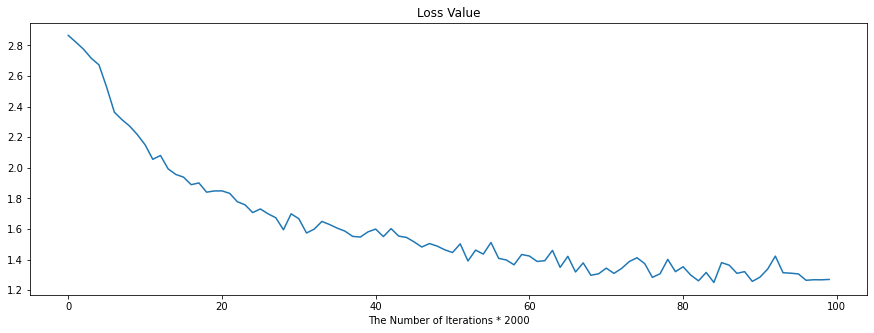

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(all_losses)
plt.title('Loss Value')
plt.xlabel('The Number of Iterations * 2000')

In [11]:
confusion_matrix=t.zeros(n_categories,n_categories)
confusion_iters=10000#生成混淆矩阵所需的迭代次数

def evaluate(line_tensor):

    hidden=rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)

    return output

for i in range(confusion_iters):

    category,line,category_tensor,line_tensor=randomTrainingExample()
    pred=categoryFromOutput(evaluate(line_tensor))
    
    #在通过tensor生成混淆矩阵时，最好以行作为实际值，以列作为预测值
    row=all_categories.index(category)#列代表预测结果
    column=all_categories.index(pred)#行代表真实结果
    confusion_matrix[row][column]+=1

for i in range(confusion_matrix.size()[0]):
    confusion_matrix[i] /= confusion_matrix[i].sum()

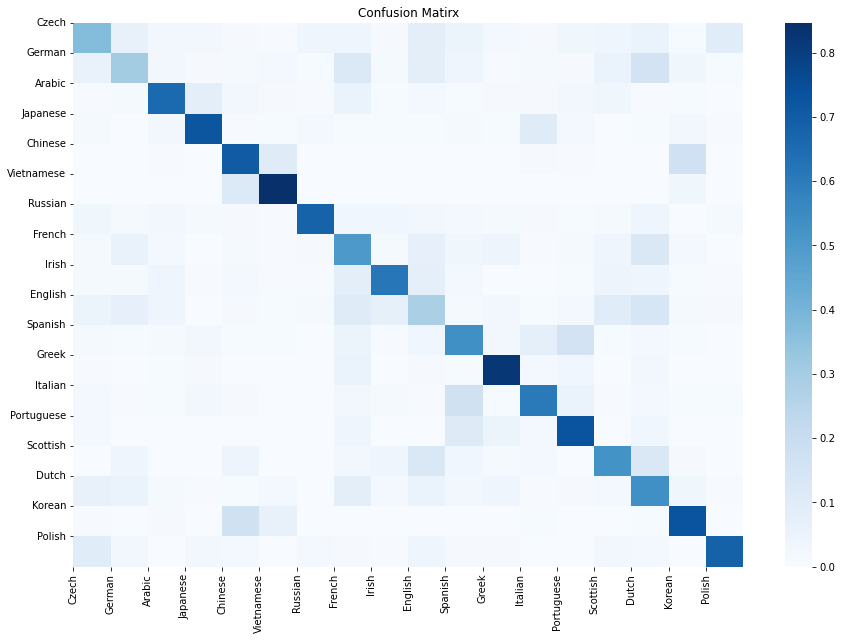

In [12]:
import seaborn as sns
import numpy as np
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix,cmap='Blues',cbar=True)
plt.xticks(np.arange(18),all_categories,rotation=90)
plt.yticks(np.arange(18),all_categories,rotation=0)
plt.title('Confusion Matirx')
plt.show()

#### （四）生成文本
通过语言种类来生成名字，以语言类别、输入字符以及隐藏单元作为输入数据，以下一个字符和隐藏单元作为输出数据

In [13]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size#用于初始化隐藏单元
        
        #本例中hidden_size设为128
        self.i2h=nn.Linear(n_categories+input_size+hidden_size,hidden_size)#18+56+128=202，128
        self.i2o=nn.Linear(n_categories+input_size+hidden_size,output_size)#18+56+128=202，56
        self.o2o=nn.Linear(output_size+hidden_size,output_size)#用以增强稳健型，56+128=184，56

        self.dropout=nn.Dropout(0.1)#随机使部分输入数据变为0，以降低过拟合、人为增加噪声
        self.softmax=nn.LogSoftmax(dim=1)
    
    def forward(self,category,input,hidden):
        input_combined=t.cat((category,input,hidden),1)#1，202

        hidden=self.i2h(input_combined)#1，202---202，128
        output=self.i2o(input_combined)#1，202---202，56

        output_combined=t.cat((hidden,output),1)
        output=self.o2o(output_combined)
        output=self.dropout(output)
        output=self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return t.zeros(1,self.hidden_size)

In [14]:
def randomTrainingExample():#与上文的不同之处在于，需要将category也进行one-hot编码
    #输入数据
    category=randomChoice(all_categories)
    category_tensor=t.zeros(1,n_categories)
    category_tensor[0][all_categories.index(category)]=1

    #输入数据，如ABCD
    line=randomChoice(category_lines[category])
    line_tensor=lineToTensor(line)

    #真实值target_tensor，用于计算损失值，如BCD55
    letter_indexes=[all_letters.index(letter) for letter in line[1:]]
    letter_indexes.append(n_letters-1)#EOS
    return line_tensor,category_tensor,t.LongTensor(letter_indexes)#为长整型

In [15]:
lr=0.0005
def train(line_tensor,category_tensor,target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden=rnn.initHidden()
    loss=0
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(category_tensor,line_tensor[i],hidden)
        #每进行一次预测，实际上是对一句话（本例中一句话只有一个单词）中某个字符的下个字符进行预测，故损失值需逐个字符计算，
        loss += criterion(output,target_tensor[i])#output是对下一个字符的预测，刚好与target_tensor的下标对应
    
    loss.backward()#单独一句话的所有字符之间共享参数

    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-lr)
    return output,loss.item()/line_tensor.size()[0]

rnn=RNN(n_letters,n_letters,128)
n_iters=100000
print_every=5000
plot_every=2000
all_losses=[]
print_loss=0
plot_loss=0

for iter in range(1,n_iters+1):
    line_tensor,category_tensor,target_tensor=randomTrainingExample()
    output,loss=train(line_tensor,category_tensor,target_tensor)
    print_loss+=loss
    plot_loss+=loss

    if iter % print_every==0:
        print(f'迭代次数为{iter}，占比{iter/n_iters*100:.0f}%，每{print_every}次迭代的平均损失值为{print_loss/print_every}')
        print_loss=0

    if iter % plot_every==0:
        all_losses.append(plot_loss/plot_every)
        plot_loss=0

迭代次数为5000，占比5%，每5000次迭代的平均损失值为3.1922144299708384
迭代次数为10000，占比10%，每5000次迭代的平均损失值为2.8533930278677855
迭代次数为15000，占比15%，每5000次迭代的平均损失值为2.72594048703655
迭代次数为20000，占比20%，每5000次迭代的平均损失值为2.633547316861558
迭代次数为25000，占比25%，每5000次迭代的平均损失值为2.5764102735185146
迭代次数为30000，占比30%，每5000次迭代的平均损失值为2.543778894201976
迭代次数为35000，占比35%，每5000次迭代的平均损失值为2.4988600476932525
迭代次数为40000，占比40%，每5000次迭代的平均损失值为2.470238950117642
迭代次数为45000，占比45%，每5000次迭代的平均损失值为2.4489999264103157
迭代次数为50000，占比50%，每5000次迭代的平均损失值为2.4248909515149206
迭代次数为55000，占比55%，每5000次迭代的平均损失值为2.4095520982628162
迭代次数为60000，占比60%，每5000次迭代的平均损失值为2.386030885213458
迭代次数为65000，占比65%，每5000次迭代的平均损失值为2.3764933223660685
迭代次数为70000，占比70%，每5000次迭代的平均损失值为2.3579362112735978
迭代次数为75000，占比75%，每5000次迭代的平均损失值为2.3472523822765483
迭代次数为80000，占比80%，每5000次迭代的平均损失值为2.3400272883160005
迭代次数为85000，占比85%，每5000次迭代的平均损失值为2.330134591950106
迭代次数为90000，占比90%，每5000次迭代的平均损失值为2.317864705927191
迭代次数为95000，占比95%，每5000次迭代的平均损失值为2.321461858485722
迭代次数为100000，占比100%，每5000次迭代的平均损失值为2.281397

Text(0.5, 0, 'The Number of Iterations * 2000')

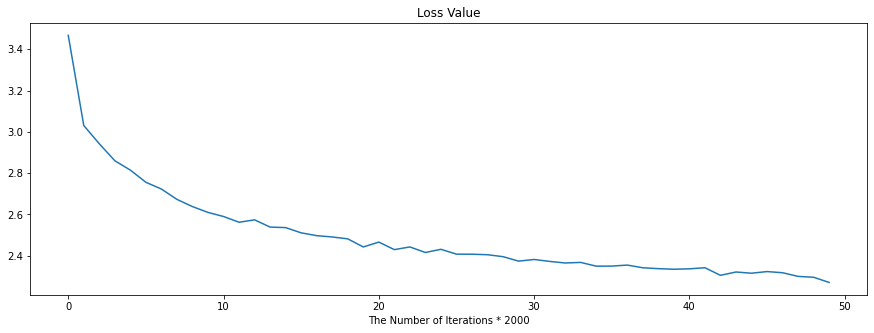

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(all_losses)
plt.title('Loss Value')
plt.xlabel('The Number of Iterations * 2000')

In [17]:
max_length=20
def sample(category,start='A'):
    category_tensor=t.zeros(1,n_categories)
    category_tensor[0][all_categories.index(category)]=1

    input_tensor=t.zeros(1,n_letters)
    input_tensor[0][all_letters.index(start)]=1

    hidden=rnn.initHidden()

    output_name=start

    for i in range(max_length):
        output,hidden=rnn(category_tensor,input_tensor,hidden)
        topv,topi=output.topk(1)
        topi=topi[0][0]
        if topi==n_letters-1:#人为设定的终止符下标是55，即任一句子的所有字符下标均不得为55，当出现55时，即认为终止
            break
        else:
            letter=all_letters[topi]
            output_name += letter
            
            input_tensor=t.zeros(1,n_letters)
            input_tensor[0][all_letters.index(letter)]=1
    return output_name

def samples(category,starts='ABC'):
    for start in starts:
        print(sample(category,start))
    print('-'*50)

In [18]:
output

tensor([[ -2.4780,  -4.7992,  -7.8075,  -4.6790,  -4.8783,  -6.1882,  -5.3283,
          -5.2953,  -3.6463,  -8.2471,  -8.4714,  -5.6993,  -5.7285,  -6.5187,
          -4.5888,  -8.3063,  -7.3922,  -4.0244,  -3.8350,  -4.6790,  -4.6760,
          -8.6161,  -8.6090,  -8.3829,  -5.8532,  -6.7052, -10.5898, -10.1838,
         -10.8147, -10.3713, -11.2946,  -4.6790, -10.4940, -10.5818, -10.5774,
         -11.2889,  -4.6790, -10.3720, -10.6482, -10.5024, -10.8687, -10.6871,
          -4.6790, -10.8138, -10.9583, -10.8572, -10.7255, -10.9266,  -4.6790,
         -10.9480, -10.6604, -11.1286, -10.6472, -10.5558, -10.8077,  -0.3113]],
       grad_fn=<LogSoftmaxBackward0>)

In [19]:
samples('Russian','WGZ')
samples('English','WGZ')
samples('Chinese','WGZ')

Wartan
Garinov
Zarinov
--------------------------------------------------
Wanter
Gorten
Zonger
--------------------------------------------------
Wai
Gan
Zhag
--------------------------------------------------
